In [1]:
# Import libraries
from paretoset import paretoset
import numpy as np
import pandas as pd
import geopandas as gpd
import momepy
import time
import copy
import networkx as nx

In [2]:
import networkx as nx
import random

# Create a 5x5 grid graph
G = nx.Graph()

# Add nodes to the graph
for i in range(5):
    for j in range(5):
        G.add_node((i, j))

# Add edges to form the grid structure
for i in range(4):
    for j in range(5):
        G.add_edge((i, j), (i + 1, j))
        G.add_edge((i, j), (i, j + 1))

# Assign costs for length and number of crossings
length_costs = [
    [1, 2, 3, 4, 5],
    [2, 3, 4, 5, 6],
    [3, 4, 5, 6, 7],
    [4, 5, 6, 7, 8],
    [5, 6, 7, 8, 9]
]

crossings_costs = [
    [1, 1, 1, 1, 1],
    [1, 2, 2, 2, 1],
    [1, 2, 3, 2, 1],
    [1, 2, 2, 2, 1],
    [1, 1, 1, 1, 1]
]

# Assign the costs for each edge
for u, v in G.edges():
    u_x, u_y = u
    v_x, v_y = v
    # length_cost = length_costs[u_x][u_y]
    # crossings_cost = crossings_costs[u_x][u_y]
    length_cost = random.random()
    crossings_cost = random.random()
    G[u][v]['length'] = length_cost
    G[u][v]['crossing'] = crossings_cost

# Print the graph information
print("Graph nodes:", G.nodes())
print("Graph edges:", G.edges(data=True))

S = (0,1)
T = (2,5)


Graph nodes: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (0, 5), (1, 5), (2, 5), (3, 5)]
Graph edges: [((0, 0), (1, 0), {'length': 0.5576991070907842, 'crossing': 0.2920003374823209}), ((0, 0), (0, 1), {'length': 0.9025404586680534, 'crossing': 0.295416153901329}), ((0, 1), (1, 1), {'length': 0.6513569297492813, 'crossing': 0.8230330256571687}), ((0, 1), (0, 2), {'length': 0.04512612218824785, 'crossing': 0.9137525121675913}), ((0, 2), (1, 2), {'length': 0.054031046214500944, 'crossing': 0.19755482493181664}), ((0, 2), (0, 3), {'length': 0.547061272034982, 'crossing': 0.9516204977262722}), ((0, 3), (1, 3), {'length': 0.948865467799548, 'crossing': 0.022158763446706087}), ((0, 3), (0, 4), {'length': 0.029485275518860488, 'crossing': 0.543147970445479}), ((0, 4), (1, 4), {'length': 0.04555947057408882, 'crossing': 0.9432852248403414}

value vectors:[array([1.41262475, 3.50999475]), array([3.70754068, 1.45708127])]
Ground-truth utility for paths in P: 106.03736744400308
DFS iterations: 21
DFS time elapsed in seconds: 0.0020339488983154297
Utility for p*: 105.99294165759635
Outer-loop time elapsed in seconds: 0.020571231842041016
Target [1.41262475 1.45708127]; Path [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (2, 5)] with cost [array([1.41262475, 3.50999475])]
Alternative path 1: [(0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
Alternative path 2: [(0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (2, 5)]


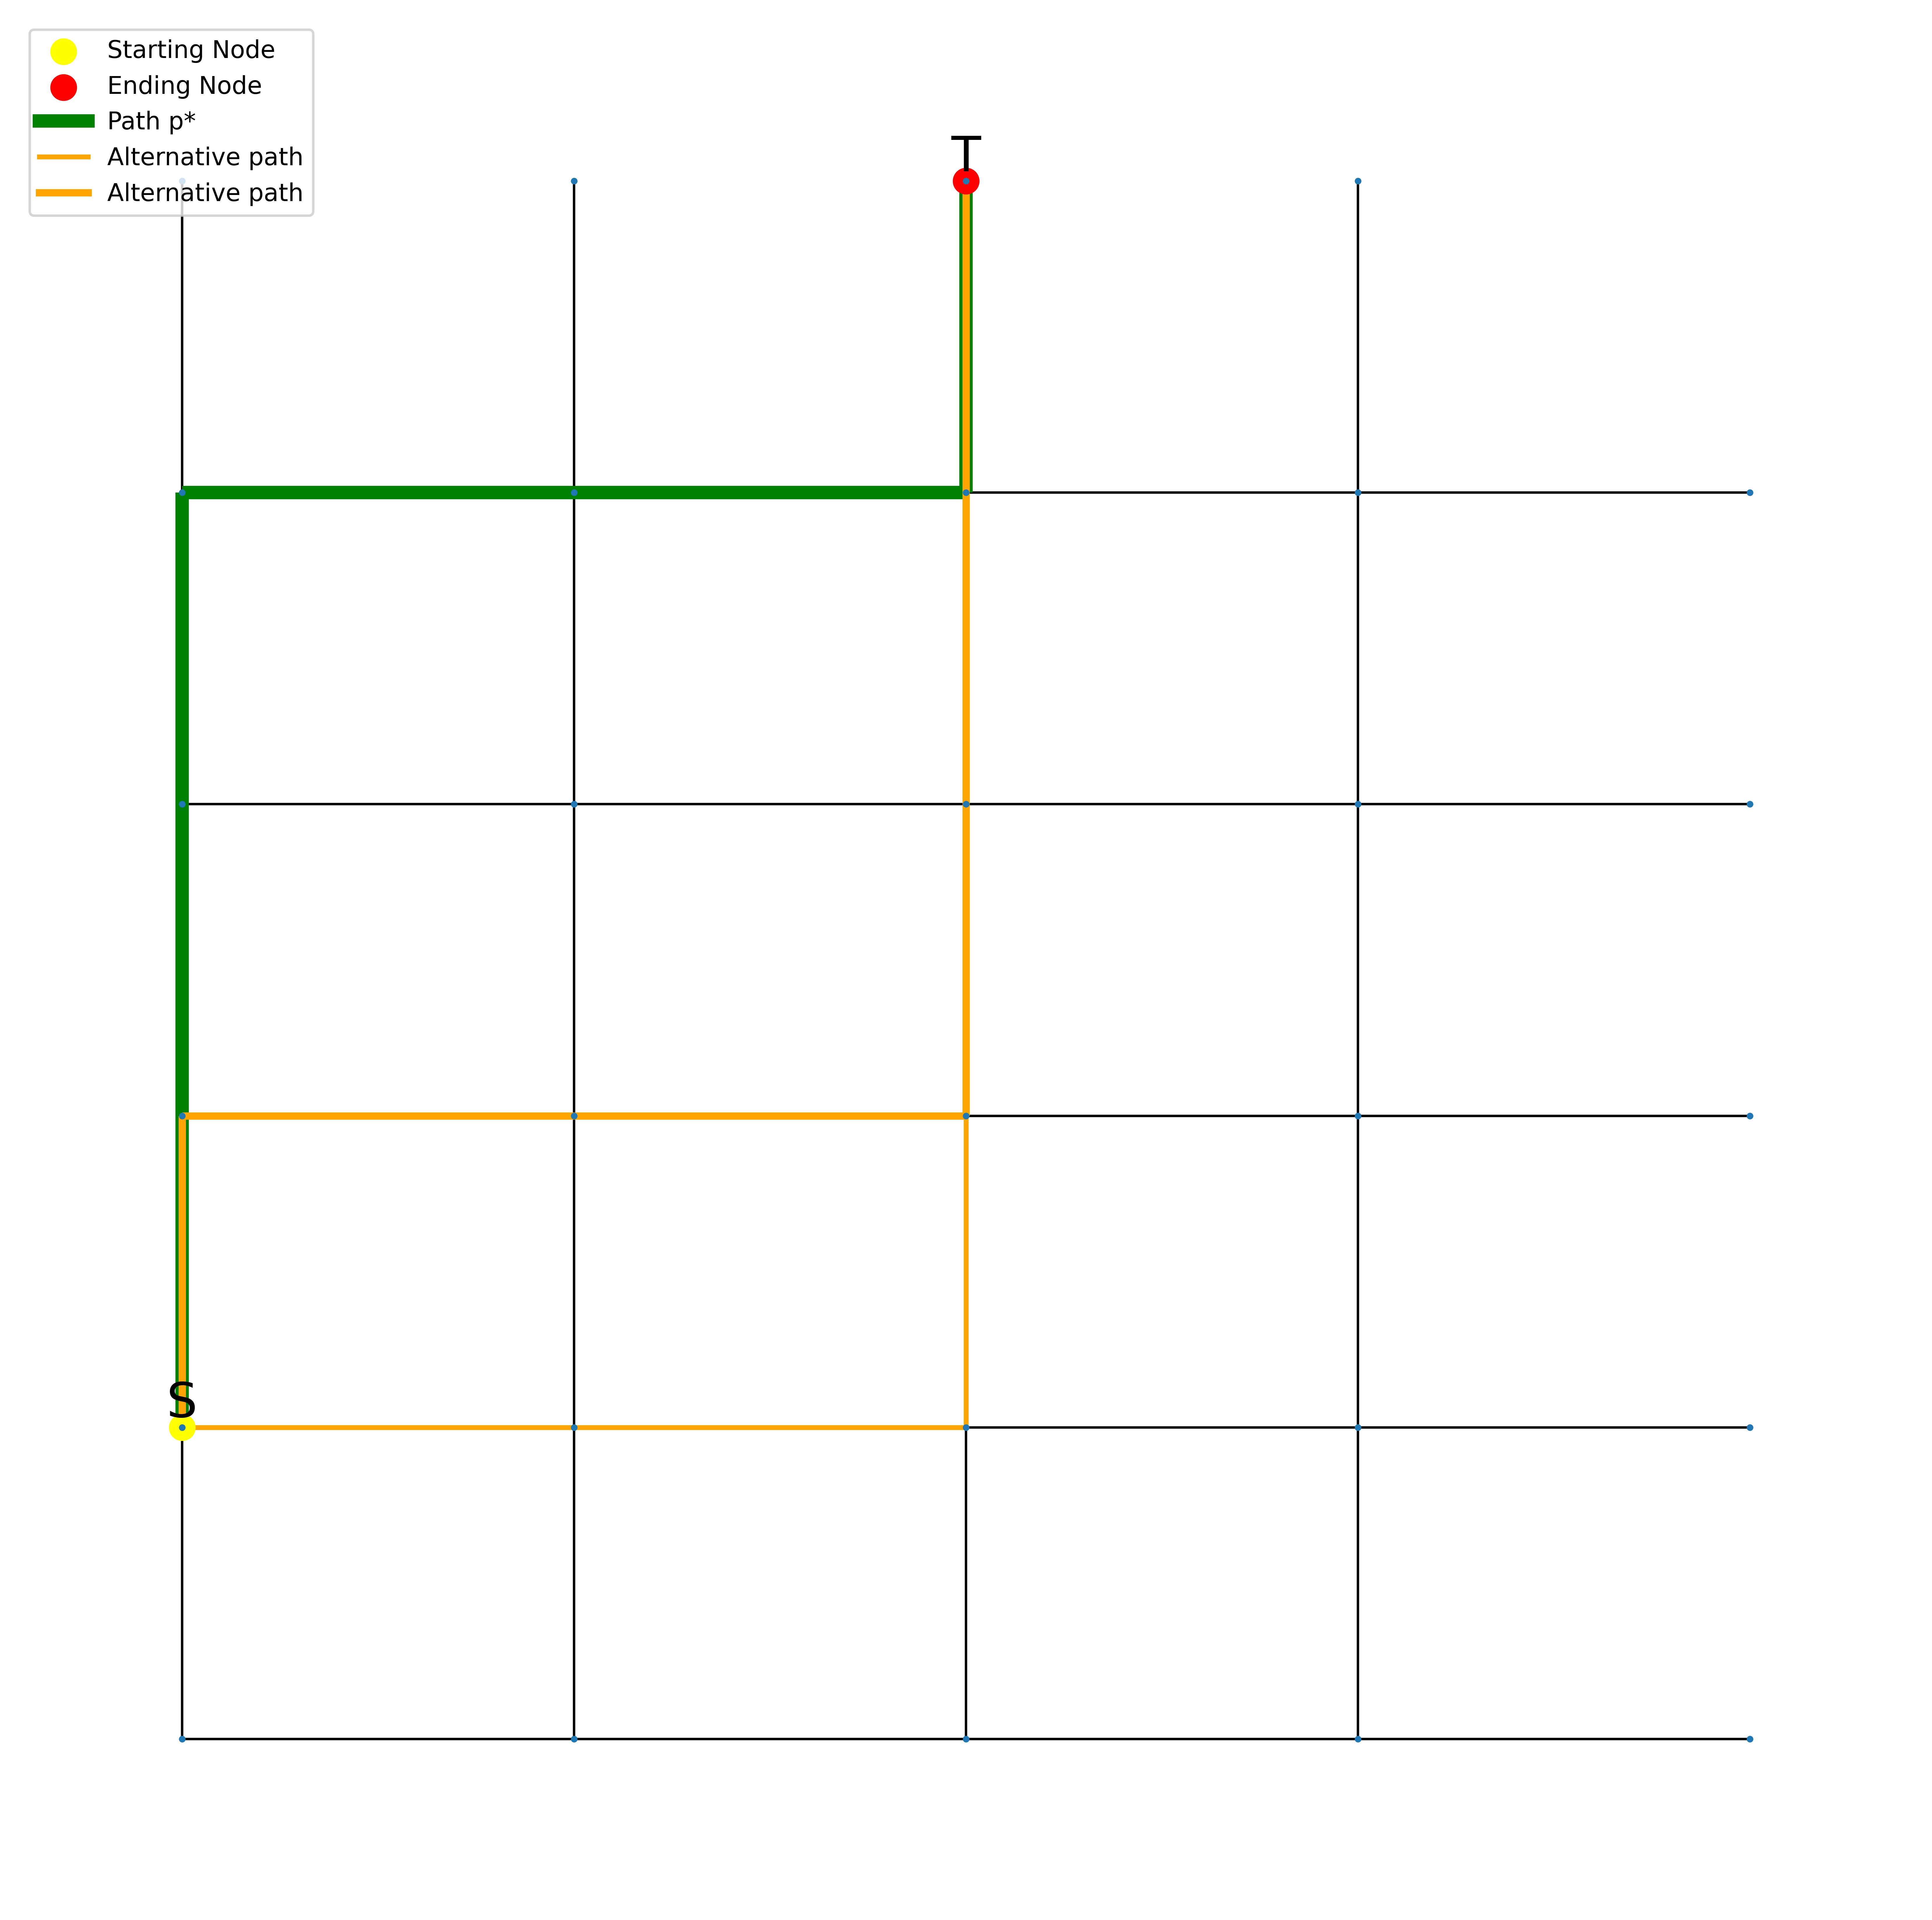

In [3]:
import outer_loop
import geopandas as gpd
import momepy
import networkx as nx
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib

# Legend
legend_text = []
legend_labels = []
# Colors
cmap = matplotlib.colormaps['tab10']  # Colormap
exclude_colors = ['green', 'blue']
new_cmap = [color for color in cmap.colors if color not in exclude_colors]
new_cmap = colors.ListedColormap(new_cmap)
# Plot
fig, ax = plt.subplots(figsize=(14, 14), dpi=600)

objectives = ('length', 'crossing')
t, p_star, val_vector_p_star, P = outer_loop.outer(G, S, T, objectives)
print(f"Target {t}; Path {p_star} with cost {val_vector_p_star}")

# Alternative paths from the Pareto set P
for i, path in enumerate(P):
    if path != p_star:
        print(f"Alternative path {i}:", path)

# All nodes and edges
nx.draw(G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax, node_size=3)

# Color p* in green
p_star_edges = list(zip(p_star[:-1], p_star[1:]))
green_p_star = 'green'
green_p_star_lwidth = 2.5 + len(P)  # Line width
legend_label = f"Path p*"
nx.draw_networkx_edges(G, pos={n: [n[0], n[1]] for n in list(G.nodes)}, edgelist=p_star_edges, ax=ax,
                       edge_color=green_p_star, width=green_p_star_lwidth)
legend_text.append(
    plt.Line2D([], [], color=green_p_star, linestyle='-', linewidth=green_p_star_lwidth, label=legend_label))
legend_labels.append(legend_label)


# Color the remaining paths in P
for i, path in enumerate(P):
    path_edges = list(zip(path[:-1], path[1:]))
    color = new_cmap(i % new_cmap.N)
    lwidth = 1.0 + (i % len(P)) * 1.0  # Line width

    if path != p_star:
        legend_label = f"Alternative path"
        nx.draw_networkx_edges(G, pos={n: [n[0], n[1]] for n in list(G.nodes)}, edgelist=path_edges, ax=ax,
                               edge_color='orange', width=lwidth)
        legend_text.append(
            plt.Line2D([], [], color='orange', linestyle='-', linewidth=lwidth, label=legend_label))
        legend_labels.append(legend_label)


# Start & end node
ax.scatter(S[0], S[1], c='yellow', marker='o', s=100, label='Starting Node')
ax.scatter(T[0], T[1], c='red', marker='o', s=100, label='Terminating Node')
ax.text(S[0], S[1], 'S', fontsize=20, ha='center', va='bottom')
ax.text(T[0], T[1], 'T', fontsize=20, ha='center', va='bottom')
start_text = plt.scatter([], [], c='yellow', marker='o', s=100)
end_text = plt.scatter([], [], c='red', marker='o', s=100)
start_label = 'Starting Node'
end_label = 'Ending Node'

# Create legend
all_handles = [start_text, end_text] + legend_text
all_labels = [start_label, end_label] + legend_labels
ax.legend(handles=all_handles, labels=all_labels)
ax.legend(handles=all_handles, labels=all_labels, loc='upper left')

# Save the image
folder_path = 'experiments'
file_name = 'ex70.png'
file_path = folder_path + '/' + file_name
plt.savefig(file_path, bbox_inches='tight')

In [4]:
def pareto_dominates(a, b):
    """Check if the vector in b Pareto dominates vector a.

    Note: The original code has been modified to work for our minimization problem.

    Args:
        a (ndarray): A numpy array.
        b (ndarray): A numpy array.

    Returns:
        bool: Whether vector b dominates vector a.
    """
    a = np.array(a)
    b = np.array(b)
    return np.all(a <= b) and np.any(a < b)


def p_prune(candidates):
    """Create a Pareto coverage set from a set of candidate points.

    References:
        .. [1] Roijers, D. M., & Whiteson, S. (2017). Multi-objective decision making. 34, 129–129.
            https://doi.org/10.2200/S00765ED1V01Y201704AIM034

    Args:
        candidates (Set[Tuple]): A set of vectors.

    Returns:
        Set[Tuple]: A Pareto coverage set.
    """
    pcs = set()
    while candidates:
        vector = candidates.pop()

        for alternative in candidates:
            if pareto_dominates(alternative, vector):
                vector = alternative

        to_remove = set(vector)
        for alternative in candidates:
            if pareto_dominates(vector, alternative):
                to_remove.add(alternative)

        candidates -= to_remove
        pcs.add(vector)
    return pcs


def pvi(G, T, objectives, max_iter=30):
    start = time.time()
    nd_vectors = [set([tuple(np.full(2, np.inf)) for _ in range(len(G.nodes))]) for _ in range(len(G.nodes))] # Initialisation of nodes
    is_last = False
    converged = False
    j=0

    for n, current_node in enumerate(G.nodes):
        if current_node == T:  # We've reached the terminal state
            nd_vectors[n] = set([(0, 0) for _ in G.nodes])
            # converged = True
            break

    # nd_vectors_update = copy.deepcopy(nd_vectors)

    # for run in range(max_iter):  # We execute the algorithm for a number of iterations.
    #     print(f'Value Iteration number: {run}')

    # while '{(inf, inf)}' in str(nd_vectors_update):
    # converged = False
    # while not converged:  # Run until convergence
    #     converged = True
    while True:
        old_vectors = copy.deepcopy(nd_vectors)
        for n, current_node in enumerate(G.nodes):  # Loop over all states. Note: current_node is an object; n=number
            if current_node == T:
                continue

            for nk, neighbor in enumerate(G.nodes): #Note: neighbor is an object; k=number

                if neighbor not in G.neighbors(current_node):
                    continue

                edge = G[current_node][neighbor]

                cost = []
                for i in objectives:
                  cost.append(edge[i])
                # print(f"cost:{cost}")
                cost = np.array(cost)
                results = nd_vectors[n].copy()

                for value_vec in nd_vectors[nk]:
                    # for value_vec in v_list:
                    # if value_vec != (np.inf, np.inf):
                    #     print("value vec:", value_vec)
                    results.add(tuple(cost+value_vec)) # The set of candidate vectors
                # print(f"results:{results}")

                results = p_prune(results)
                # print(f"results pruned:{results}")

                # if nd_vectors[n][nk] != results:
                #     converged = False
                nd_vectors[n] = results
                # print(f"nd_vectors:{nd_vectors}")

        j+=1
        # if has_converged(nd_vectors, old_vectors, 0.0001):
        #     break
        if nd_vectors == old_vectors:
            break
        # Check for convergence
        # if delta < 0.0001:
        #     break

        # if converged:
        #     break

        nd_vectors = copy.deepcopy(nd_vectors)  # Else perform a deep copy and go again.

    print(f'Iterations: {j}')
    end = time.time()
    elapsed_seconds = (end - start)
    print("Seconds elapsed: " + str(elapsed_seconds))

    return nd_vectors

# def has_converged(nd_vectors, old_vectors, epsilon):
#     for i in range(len(nd_vectors)):
#         if not np.allclose(list(nd_vectors[i])[0], list(old_vectors[i])[0], atol=epsilon):
#                 return False
#     return True

pvi_result = pvi(G, (3,5), objectives)
print(pvi_result)

#target = [1.7902152  1.78189354]

Iterations: 9
Seconds elapsed: 0.0635221004486084
[{(3.6080154674785643, 2.431928723523127), (2.8884779197961437, 4.033156323661417), (2.5867005445699656, 4.57217144964202), (3.059457004710682, 2.942496944345218), (4.260749833728566, 1.9909942632644082)}, {(3.9790760231537705, 2.223841815478634), (2.1569165460426287, 2.647080790443889), (1.6841600859019121, 4.27675529574069), (1.9859374611280902, 3.7377401697600874)}, {(1.6390339637136644, 3.3630027835730987), (2.111790423854381, 1.7333282782762975), (1.9408113389398425, 2.823987657592496)}, {(3.2778831638500714, 1.3687500906205257), (1.0919726916786825, 2.4113822858468263), (2.607656429136292, 1.4130085587720158)}, {(1.0624874161598221, 1.8682343154013472)}, {(2.6856219926760656, 4.16471254120124), (3.05031636038778, 2.139928386040806), (2.8793372754732416, 3.230587765357004), (3.703050726637782, 1.6989939257820872)}, {(2.3102903594427726, 3.866527405240618), (2.5040056422399486, 2.932402629396382), (2.674984727154487, 1.8417432500801

In [88]:
def track_policy(G, S, T, vec, pvi_vec, tol=1e-8):
        """Track a policy from its return vector.

        Args:
            vec (array_like): The return vector to track.
            env (gym.Env): The environment to track the policy in.
            tol (float, optional): The tolerance for the return vector. (Default value = 1e-3)
        """
        target = np.array(vec)  # SET THE TARGET YOU WANT TO ACQUIRE. SO IN YOUR CASE THIS IS THE VECTOR BELONGING TO THE OPTIMAL PATH.
        path = []  # START THE “PATH” AT THE START NODE HERE.
        terminated = False  # WHETHER WE ARE AT THE TERMINAL NODE.
        total_rew = np.zeros(2)  # THE REWARD WE HAVE ACCUMULATED SO FAR IN THE PATH
        im_rew = np.zeros(2)

        for n, current_node in enumerate(G.nodes):
            if current_node == T:
                # total_rew += im_rew
                path.append(current_node)
                break
            else:  # WHILE WE DO NOT REACH THE GOAL NODE.
                closest_dist = np.inf  # THIS IS THE DISTANCE TO THE CLOSEST VALUE VECTOR WE CAN GET
                closest_action = 0  # THIS IS THE ACTION, I.E. FOR YOU THE NEIGHBOUR, THAT WE MUST GO WITH TO MOVE ALONG THE CORRECT PATH.
                found_action = False  # WHETHER WE THINK WE FOUND THE CORRECT NEIGHBOUR.
                new_target = target   # THE NEW TARGET

                for nk, action in enumerate(G.neighbors(current_node)):  # THIS CHECKS OVER THE POSSIBLE OPTIONS YOU CAN DO. FOR YOU THIS WOULD BE THE NEIGHBOURS OF YOUR CURRENT STATE.

                    # CHECK WHAT COST IS ASSOCIATED WITH THE EDGE BETWEEN YOUR CURRENT NODE AND THE NEIGHBOUR.
                    edge = G[current_node][action]
                    im_rew = np.array([edge['length'], edge['crossing']])
                    # print(f"im_rew:{im_rew}")
                    non_dominated_set = pvi_vec[n]  # GET THE NON DOMINATED SET FROM PVI AT THIS NODE-NEIGHBOUR

                    for q in non_dominated_set:  # CHECK FOR EVERY VECTOR IN THIS SET
                        q = np.array(q)
                        dist = np.sum(np.abs(q + im_rew - target))  # CHECK THE DISTANCE BETWEEN YOUR TARGET (SO WHAT YOU STILL NEED TO GET) AND THE VALUE VECTOR
                        if dist < closest_dist:  # IF THE DISTANCE IS BETTER THAN WHAT YOU GOT SO FAR.
                            closest_dist = dist  # SET THIS DISTANCE AS THE BEST DISTANCE.
                            closest_action = action  # TAKE THE ACTION.
                            new_target = q  # UPDATE THE TARGET (I.E. REMOVE THE IMMEDIATE COST)
                            # print(new_target)
                            if dist < tol:  # IF THE DISTANCE IS GOOD ENOUGH.
                                found_action = True  # JUST SAY YOU FOUND THE CORRECT NEIGHBOUR
                                path.append(current_node)
                                # print("current_node", current_node)
                                break  # AND STOP THE LOOP


                    if found_action:
                        # path.append(closest_action)
                        break

                current_node = closest_action  # TAKE THE EDGE THAT YOU THINK IS BEST
                # edge2 = G[closest_action][current_node]
                total_rew = im_rew # UPDATE THE REWARD YOU ACQUIRED from tracking the policy and should equal the target vector in the end
                target = new_target  # UPDATE THE TARGET
                # if current_node not in path:
                #     path.append(current_node)


        return total_rew, path  # YOU HAVE TO RETURN THE TRAVERSED PATH HERE AS WELL

tt = (1.7902152,  1.78189354)
S = (0,1)
T = (2,5)
ress, pathh = track_policy(G, S, T, tt, pvi_result)
print(ress, pathh)
#Target [1.7902152  1.78189354]; Path [(0, 1), (1, 1), (1, 2), (2, 2), (2, 3), (2, 4), (2, 5)] with cost [array([1.7902152 , 3.30474639])]
#Alternative path 1: [(0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (2, 5)]
#Alternative path 2: [(0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (2, 5)]


[0.23305145 0.03019994] [(0, 1), (1, 2), (2, 3), (3, 1), (3, 2), (3, 3), (3, 4), (2, 5)]


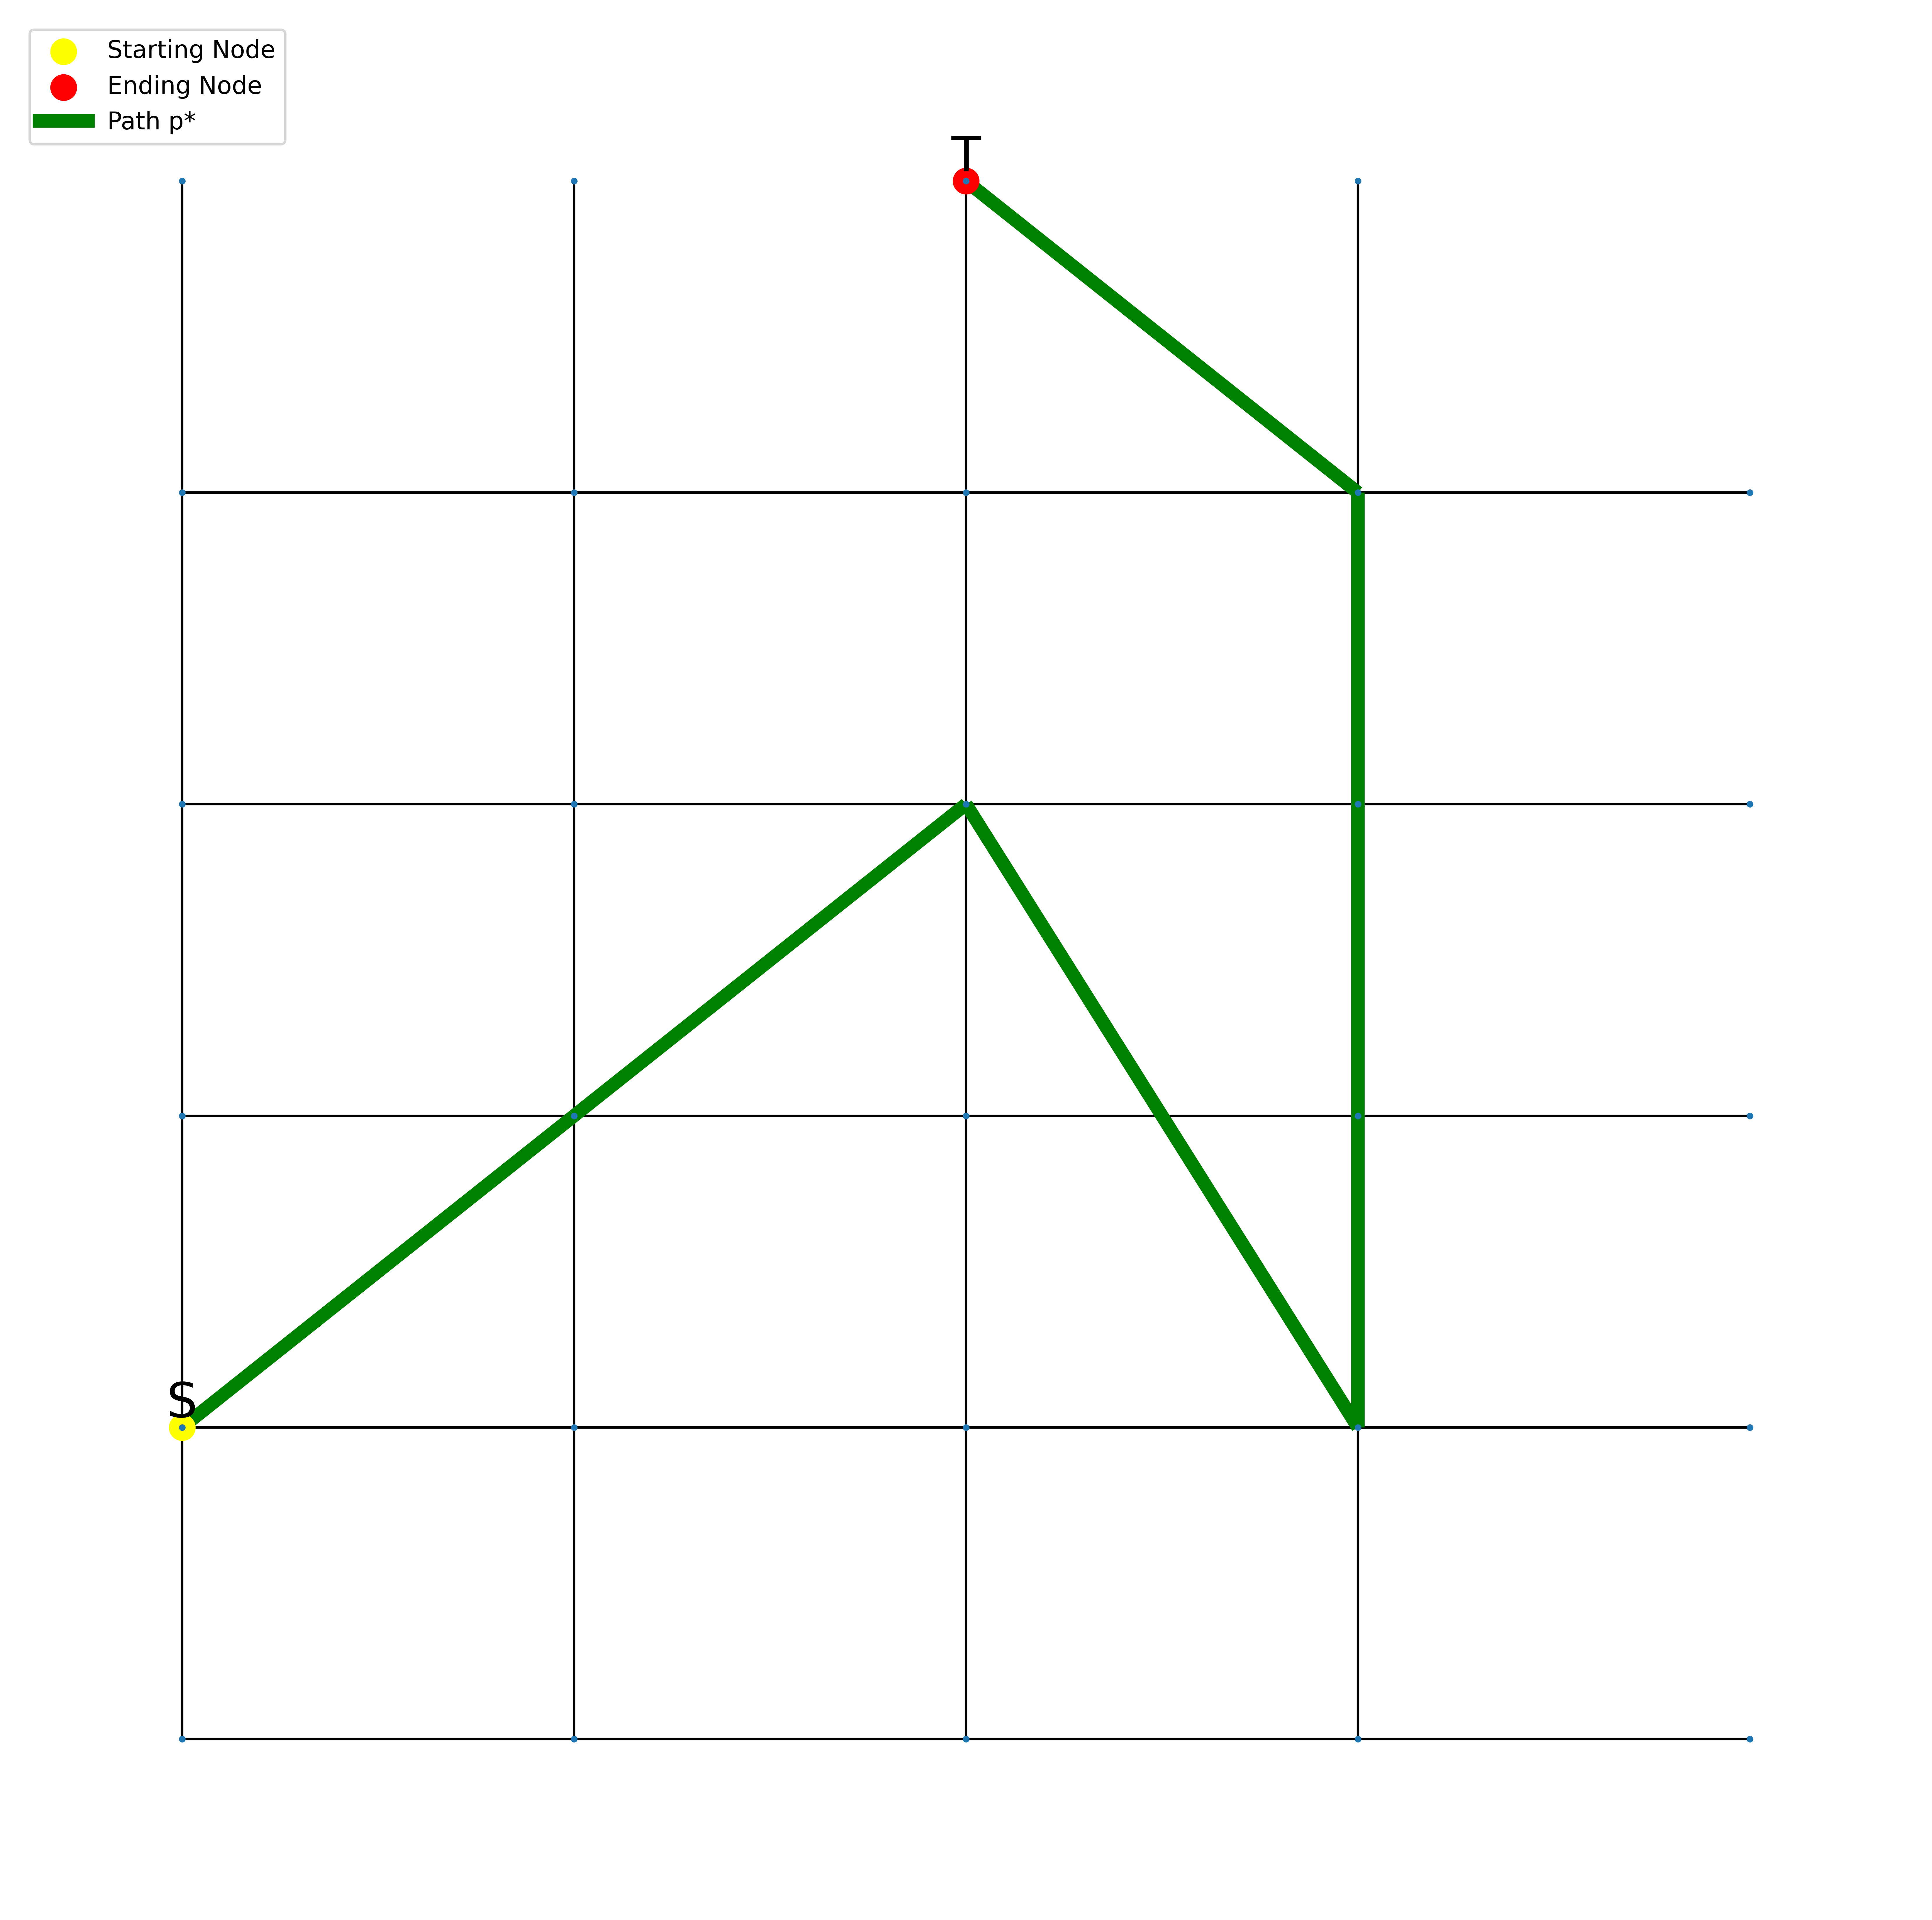

In [89]:
# Legend
legend_text = []
legend_labels = []
# Colors
cmap = matplotlib.colormaps['tab10']  # Colormap
exclude_colors = ['green', 'blue']
new_cmap = [color for color in cmap.colors if color not in exclude_colors]
new_cmap = colors.ListedColormap(new_cmap)
# Plot
fig, ax = plt.subplots(figsize=(14, 14), dpi=600)
# All nodes and edges
nx.draw(G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax, node_size=3)

# Color p* in green
p_star_edges = list(zip(pathh[:-1], pathh[1:]))
green_p_star = 'green'
green_p_star_lwidth = 2.5 + len(P)  # Line width
legend_label = f"Path p*"
nx.draw_networkx_edges(G, pos={n: [n[0], n[1]] for n in list(G.nodes)}, edgelist=p_star_edges, ax=ax,
                       edge_color=green_p_star, width=green_p_star_lwidth)
legend_text.append(
    plt.Line2D([], [], color=green_p_star, linestyle='-', linewidth=green_p_star_lwidth, label=legend_label))
legend_labels.append(legend_label)

# Start & end node
ax.scatter(S[0], S[1], c='yellow', marker='o', s=100, label='Starting Node')
ax.scatter(T[0], T[1], c='red', marker='o', s=100, label='Terminating Node')
ax.text(S[0], S[1], 'S', fontsize=20, ha='center', va='bottom')
ax.text(T[0], T[1], 'T', fontsize=20, ha='center', va='bottom')
start_text = plt.scatter([], [], c='yellow', marker='o', s=100)
end_text = plt.scatter([], [], c='red', marker='o', s=100)
start_label = 'Starting Node'
end_label = 'Ending Node'

# Create legend
all_handles = [start_text, end_text] + legend_text
all_labels = [start_label, end_label] + legend_labels
ax.legend(handles=all_handles, labels=all_labels)
ax.legend(handles=all_handles, labels=all_labels, loc='upper left')

# Save the image
folder_path = 'experiments'
file_name = 'ex71.png'
file_path = folder_path + '/' + file_name
plt.savefig(file_path, bbox_inches='tight')
